In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")
def del_order_mark(df):
    new_Reputation = []
    for i in range(len(df)): # delete the order mark in "repulation"
        new_Reputation.append(df['Reputation'][i][1:])
    df.Reputation = new_Reputation
    return df

In [2]:
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")
bq_assistant.list_tables()

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

# ABSTRACT
Stack Overflow (SO) is a community-based question answering service that targets developers and software engineers and has achieved significant success. This notebook explored the characteristics of SO in terms of its users, questions and tags with the data provided. The main findings of this work include the polarization of SO users, the question-answering pyramid of SO and the topical trend in the last decade.

### NOTE: Kaggle is updating the data. Your result of running the code could be different

# 1.USER-BASED ANALYSIS
## 1.1 User Type
Users can be classified based on their behavior in SO. There are four types of user defined in this section, i.e. questioner, answerer, question-and-answerer, and do-nothinger.<br/> * Questioner is defined to be the user who only asks questions. <br/> * Answerer refers to the user only answering questions. <br/>*  Question-and-answerer is the user who both ask and answer questions. <br/> * Do-Nothinger, as the name suggests, never asks or answers any question. <br/><br/>Please note that do-nothingers are not really doing nothing in SO, they do not ask or answer question, but they would vote on other questions or answers. The distribution of the four types of users is shown below

In [3]:
# How many users are questioner ?
query1 = '''
select count(distinct q.owner_user_id)
from `bigquery-public-data.stackoverflow.posts_questions` q
left join `bigquery-public-data.stackoverflow.posts_answers` a
on q.owner_user_id = a.owner_user_id
where a.owner_user_id is null
'''

# How many users are answerer ?
query2 = '''
select count(distinct a.owner_user_id)
from `bigquery-public-data.stackoverflow.posts_answers` a
left join `bigquery-public-data.stackoverflow.posts_questions` q
on a.owner_user_id = q.owner_user_id
where q.owner_user_id is null
'''

# How many users are question-and-answerer ?
query3='''
select count( distinct q.owner_user_id)
from `bigquery-public-data.stackoverflow.posts_questions` q
inner join `bigquery-public-data.stackoverflow.posts_answers` a 
on q.owner_user_id = a.owner_user_id
'''

# How many users are do-nothinger ?
query4='''
select count(id)
from `bigquery-public-data.stackoverflow.users` u
left join (
    select distinct owner_user_id
    from `bigquery-public-data.stackoverflow.posts_answers`
    union all
    select distinct owner_user_id
    from `bigquery-public-data.stackoverflow.posts_questions`) b
on u.id = b.owner_user_id
where b.owner_user_id is null
'''

# Execute the queries
questioner = stackOverflow.query_to_pandas_safe(query1).iat[0,0]
answerer = stackOverflow.query_to_pandas_safe(query2).iat[0,0]
question_and_answerer = stackOverflow.query_to_pandas_safe(query3).iat[0,0]
do_nothinger = stackOverflow.query_to_pandas_safe(query4).iat[0,0]
num_user = stackOverflow.query_to_pandas_safe("select count(*) from `bigquery-public-data.stackoverflow.users` ").iat[0,0]

# Show result
user_type_df = pd.DataFrame({"Number of Users": [questioner, answerer, question_and_answerer, do_nothinger, num_user]})
user_type_df["Percentage(%)"] = round(user_type_df["Number of Users"] / num_user * 100,2)
user_type_df.index = ["Questioner", "Answerer", "Question-and-answerer", "Do-nothinger", "Total"]
display(user_type_df)

,Number of Users,Percentage(%)
Questioner,2423104,19.41
Answerer,970965,7.78
Question-and-answerer,1406490,11.27
Do-nothinger,7684601,61.55
Total,12485155,100.00


The result is surprising in terms of the percentage of do-nothinger. There are 61.55% users being inactive all the time never asking or answering any question whereas only 38.46% active users have asked or answered at least one question. One possible explanation of the fact that most users are inactive is that for most users they can always find similar questions in SO, which results in no need for them to post a new question. On the other hand, they are not professional enough to provide answers to other questions, so they are eventually doing nothing. 
<br/><br/>However, SO is still successful even though there are only relatively small part of users being active. The posting frequency of them is expected to be high enough to cancel the negative impact brought by inactive users. The posting frequency will be discussed later


## 1.2 User Reputation
The three most important activities in SO are asking, answering, and editing. A user gains reputation when his post is voted up or the suggested edit is accepted by other users. Basically, the more reputation a user has, the more professional he is.
<br/><br/>In this section, every user is labeled as level 1, level 2, level 3, level 4, and level 5 if his reputation is in the range of 1-100, 101-1000, 1001-10000, 10001-10000 or >100000. The level of the user is expected to has an effect on the relative number of the question and answer of that group. The result is shown in Table 2.2


In [4]:
query1 = '''
SELECT
    rep_range AS Reputation,
    COUNT(*) AS Users,
    SUM(asked) AS Asked_question,
    SUM(unanswered) AS Unanswered_question,
    SUM(answered) AS Contributed_answer
FROM(
    SELECT 
        CASE
            WHEN reputation BETWEEN 1 AND 100 THEN '11- 100'
            WHEN reputation BETWEEN 101 AND 1000 THEN '2101- 1000'
            WHEN reputation BETWEEN 1001 AND 10000 THEN '31001- 10000'
            WHEN reputation BETWEEN 10001 AND 100000 THEN '410001- 100000'
            WHEN reputation > 100000 THEN '5> 100000'
        END AS rep_range,
        asked,
        answered,
        unanswered
    FROM(    
        SELECT id AS user_id, reputation, asked, answered, unanswered
        FROM `bigquery-public-data.stackoverflow.users` u
        LEFT JOIN(
            SELECT owner_user_id AS user_id, COUNT(*) AS asked
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            GROUP BY user_id
        ) q ON u.id = q.user_id
        LEFT JOIN(
            SELECT owner_user_id AS user_id, COUNT(*) AS answered
            FROM `bigquery-public-data.stackoverflow.posts_answers`
            GROUP BY user_id
        ) a ON u.id = a.user_id
        LEFT JOIN(
            SELECT owner_user_id AS user_id, COUNT(*) AS unanswered 
            FROM (
                SELECT owner_user_id
                FROM `bigquery-public-data.stackoverflow.posts_questions`
                WHERE answer_count=0
            )
            GROUP BY user_id
        ) ua ON u.id = ua.user_id
    )
)
GROUP BY rep_range
ORDER BY rep_range
'''

profile = del_order_mark(stackOverflow.query_to_pandas_safe(query1))
profile.index = ["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"]
display(profile)

# normalize the profile
profile_per = profile.copy()
profile_per.Users = round(100 * profile_per.Users / profile_per.Users.sum(),5)
profile_per.Asked_question = round(100 * profile_per.Asked_question / profile_per.Asked_question.sum(),2)
profile_per.Unanswered_question = round(100 * profile_per.Unanswered_question / profile_per.Unanswered_question.sum(),2)
profile_per.Contributed_answer = round(100 * profile_per.Contributed_answer / profile_per.Contributed_answer.sum(),)
profile_per.rename(columns = {'Users':'Users(%)','Asked_question':'Asked_question(%)','Unanswered_question':'Unanswered_question(%)','Contributed_answer':'Contributed_answer(%)'},inplace=True)
display(profile_per)

,Reputation,Users,Asked_question,Unanswered_question,Contributed_answer
Level 1,1- 100,11502163,6655923,1316625,2884345
Level 2,101- 1000,774130,5965848,819608,5684791
Level 3,1001- 10000,187729,5074557,511623,9900629
Level 4,10001- 100000,20246,1462151,88979,7757810
Level 5,> 100000,887,77189,2683,2964958


,Reputation,Users(%),Asked_question(%),Unanswered_question(%),Contributed_answer(%)
Level 1,1- 100,92.12671,34.60,48.06,10.0
Level 2,101- 1000,6.20040,31.01,29.92,19.0
Level 3,1001- 10000,1.50362,26.38,18.68,34.0
Level 4,10001- 100000,0.16216,7.60,3.25,27.0
Level 5,> 100000,0.00710,0.40,0.10,10.0


Level 1 user is the largest group in SO. They are asking most questions but provide least amount of answers. However, the amount of questions from this group (34.60%) is roughly the same as that of level 2 user (31.01%) whose amount is far fewer than level 1 user. Therefore, it is possible that most level 1 users are do-nothingers. In a word, level 1 users ask the most but answer the least.
<br/><br/>There are only 1.67288% professional users (level 3, 4, 5) in SO. The amount of question from these groups are much fewer than that of level 1 and 2 users but they provide more than 70% answers. In a word, professional users ask the least but answer the most.
<br/><br/>Level 2 user has almost the same amount of question as level 1 user, but they provide more answers than that of level 1 user. Thus, level 2 user has the characteristic of both level 1 user and professional user. In other words, they ask fairly a lot of questions like level 1 user but also provide many answers like professional user.


## 1.3 User Posting Frequency
Based on the result from last section, reputation of the user does have an impact on his post. This section is trying to answer the question as “How often do users of each level post?” The result is shown below

In [5]:
query1 = '''
select a.rep_range as Reputation, (num_ans + num_que) as num_post
from(
    select rep_range, sum(num_ans) as num_ans
    from(
        select 
            case
                when reputation between 1 and 100 then '11- 100'
                when reputation between 101 and 1000 then '2101- 1000'
                when reputation between 1001 and 10000 then '31001- 10000'
                when reputation between 10001 and 100000 then '410001- 100000'
                when reputation > 100000 THEN '5> 100000'
            end as rep_range,
            num_ans
        from(
        select reputation, num_ans
        from `bigquery-public-data.stackoverflow.users`
        inner join(
            select owner_user_id, count(*) as num_ans
            from `bigquery-public-data.stackoverflow.posts_answers`
            group by owner_user_id)
        on id = owner_user_id)
        )
    group by rep_range) a
inner join(
    select rep_range, sum(num_que) as num_que
    from(
        select 
            case
                when reputation between 1 and 100 then '11- 100'
                when reputation between 101 and 1000 then '2101- 1000'
                when reputation between 1001 and 10000 then '31001- 10000'
                when reputation between 10001 and 100000 then '410001- 100000'
                when reputation > 100000 THEN '5> 100000'
            end as rep_range,
            num_que
        from(
        select reputation, num_que
        from `bigquery-public-data.stackoverflow.users`
        inner join(
            select owner_user_id, count(*) as num_que
            from `bigquery-public-data.stackoverflow.posts_questions`
            group by owner_user_id)
        on id = owner_user_id)
        )
    group by rep_range) b
on a.rep_range = b.rep_range
order by Reputation
'''
num_post = del_order_mark(stackOverflow.query_to_pandas_safe(query1))
num_post.index = ["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"]
num_post["per_user"] = num_post.num_post / profile.Users 
num_post["per_user_per_month"] = num_post["per_user"] / (11 * 12+5) # the oldest post is 2008.7.31, the latest is 2019.12.1
display(num_post)

,Reputation,num_post,per_user,per_user_per_month
Level 1,1- 100,9540268,0.829433,0.006054
Level 2,101- 1000,11650639,15.049977,0.109854
Level 3,1001- 10000,14975186,79.770233,0.582264
Level 4,10001- 100000,9219961,455.396671,3.324063
Level 5,> 100000,3042147,3429.703495,25.034332


Although level 1 user is the largest group in SO, they post far less often than any other group. This verifies the assumption that most level 1 users are do-nothingers.
<br/><br/>Level 5 user stands out from the table as each user has more than 3429 posts on average, which is 925 times greater than the average, and the posting frequency is 913 times higher than the average. This is good news to SO community because they post very often (almost 1 post / day) to help less professional user with their questions.

## 1.4 Summary
Based on the observation of this part, we can conclude that users of SO community are highly polarized in the sense that: 1) In terms of user type, there are 38% doers but 62% do-nothingers; 2) More than 90% users are novice user while there are only 1.7% professional users; 3) Tiny part of users (level 5 users) are posting much frequently than other users.


# 2. QUSESTION-BASED ANALYSIS
Question is no doubt one of the most important components of SO. 86% questions on SO are answered in the past 11 years, which is relatively good, but the answer rate of each year is decreasing as shown below

,Year,Number_of_Questions,Percent_Questions_with_Answers
0,2008,57950,99.9
1,2009,342579,99.6
2,2010,692334,99.0
3,2011,1193750,97.4
4,2012,1635435,94.9
5,2013,2048685,91.9
6,2014,2153444,88.8
7,2015,2207477,86.7
8,2016,2210822,85.0
9,2017,2127273,83.3


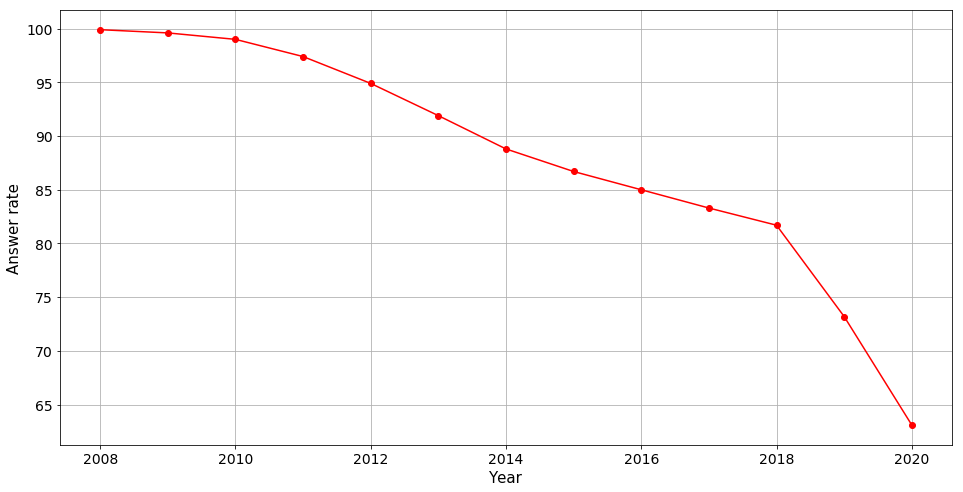

In [6]:
query1 = """SELECT
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 1) AS Percent_Questions_with_Answers
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
ORDER BY
  Year;
        """
answer_rate = stackOverflow.query_to_pandas_safe(query1)
display(answer_rate)
fig = plt.figure()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.rc('grid', linestyle="dotted", color='gray')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Answer rate', fontsize=15)
plt.plot(answer_rate['Year'], answer_rate['Percent_Questions_with_Answers'],'ro-')
fig.set_size_inches(16, 8)

It is helpful to know the source of answered and unanswered question or, in other words, “Where are the answered and unanswered questions from?”
The relative amount of answered and unanswered question from each level of user is shown below


In [7]:
profile_per["Answer_rate(%)"] = round((profile["Asked_question"] - profile["Unanswered_question"]) / profile["Asked_question"] * 100, 2)
display(profile_per)

,Reputation,Users(%),Asked_question(%),Unanswered_question(%),Contributed_answer(%),Answer_rate(%)
Level 1,1- 100,92.12671,34.60,48.06,10.0,80.22
Level 2,101- 1000,6.20040,31.01,29.92,19.0,86.26
Level 3,1001- 10000,1.50362,26.38,18.68,34.0,89.92
Level 4,10001- 100000,0.16216,7.60,3.25,27.0,93.91
Level 5,> 100000,0.00710,0.40,0.10,10.0,96.52


The result shows that 60% answered questions are from level 3 and 4 users and 76% unanswered questions are from level 1 and 2 users.
<br/><br/>level 1 user has most question (33.69%), but least amount of answered questions (9.56%) are originally raised by them. Besides, almost half of the unanswered questions are raised by level 1 user. 
<br/><br/>Level 2 user has similar amount of questions as level 1 user, but the relative amount of answered question of them is 10% higher than that of level user and the unanswered questions from them is 16% less. One could assume that level 2 user are better at asking question and getting themselves understood.
<br/><br/>In fact, it is noticeable that questions from higher-level user are more likely to be answered (as answer rate increases from level 1 user to level 5 user). This is reasonable as higher-level user is supposed to be asking a clear question, which increase the possibility of the question to be answered.
<br/><br/>Although there are already many guidelines of how to ask a good question in SO, they do not seem to work well since level 1 and 2 users are still the main source of unanswered questions. Thus, to improve the answer rate, SO could make special guideline exclusively for those novice users.


### I dont really have good analysis for the following part. I will just leave the code without analysis

Text(0.5,1,'Frequency distribution of comment count')

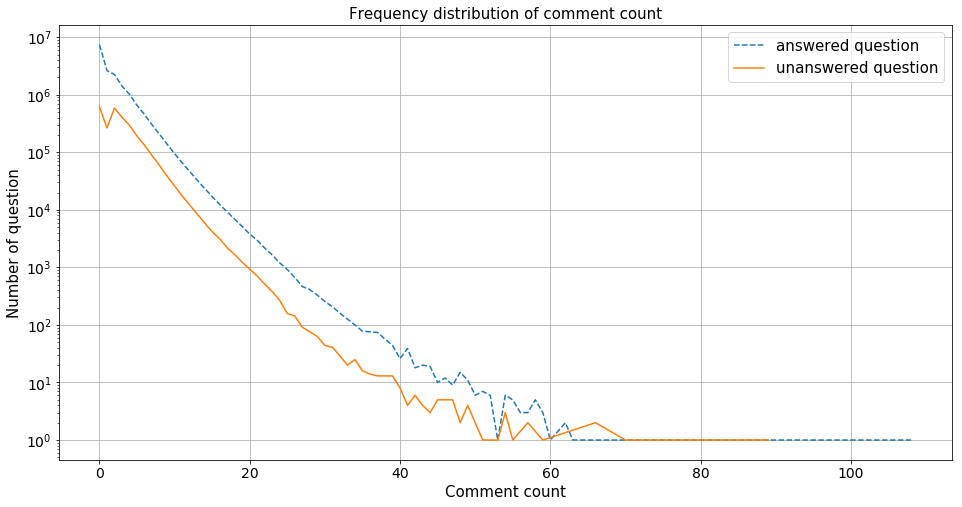

In [8]:
# the distribution of comment number

query1 = '''
select comment_count, count(*) as num
from `bigquery-public-data.stackoverflow.posts_questions`
where answer_count = 0
group by comment_count
order by comment_count asc
'''

query2 = '''
select comment_count, count(*) as num
from `bigquery-public-data.stackoverflow.posts_questions`
where answer_count > 0
group by comment_count
order by comment_count asc
'''


comment_count_unanswered = stackOverflow.query_to_pandas_safe(query1)
comment_count_answered = stackOverflow.query_to_pandas_safe(query2)


labelsize = 15
plt.figure(figsize=(16,8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

x1 = comment_count_answered.comment_count
y1 = comment_count_answered.num

x2 = comment_count_unanswered.comment_count
y2 = comment_count_unanswered.num

plt.plot(x1,y1, label="answered question",linestyle='--')
plt.plot(x2,y2, label="unanswered question")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel('Comment count',fontsize = labelsize)
plt.ylabel('Number of question',fontsize = labelsize)
plt.grid(True)
plt.legend(fontsize=15)
plt.title("Frequency distribution of comment count", fontsize=labelsize)


Text(0.5,1,'Cumulative distribution function of comment count')

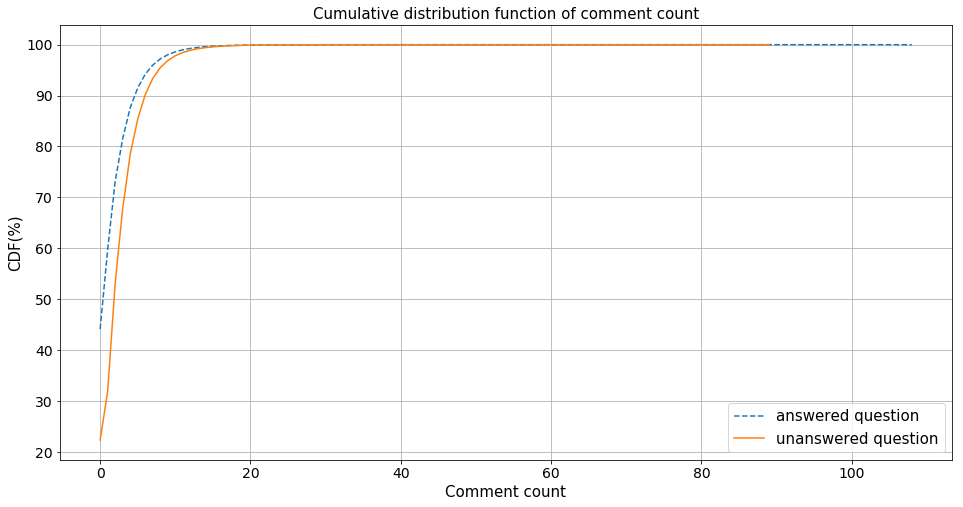

In [9]:
labelsize = 15
plt.figure(figsize=(16,8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

x1 = comment_count_answered.comment_count
y1 = np.cumsum(comment_count_answered.num)
y1 = 100 * y1 / y1.max()

x2 = comment_count_unanswered.comment_count
y2 = np.cumsum(comment_count_unanswered.num)
y2 = 100 * y2 / y2.max()

plt.plot(x1,y1, label="answered question",linestyle='--')
plt.plot(x2,y2, label="unanswered question")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel('Comment count',fontsize = labelsize)
plt.ylabel('CDF(%)',fontsize = labelsize)
plt.grid(True)
plt.legend(fontsize=15)
plt.title("Cumulative distribution function of comment count", fontsize=labelsize)

### What is the reputation of the user making comments to answered and unanswered questions? 

Text(0.5,1,'Reputation of the user making comments to answered questions')

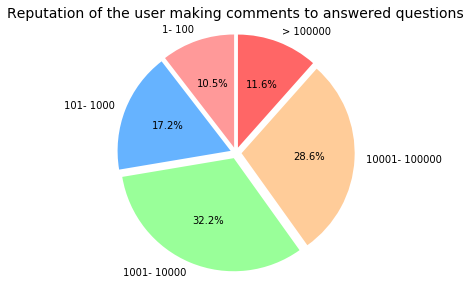

In [3]:
# Reputation of the user making comments to answered questions
query1 = '''
select 
    case
        when uc.reputation between 1 and 100 then '11- 100'
        when uc.reputation between 101 and 1000 then '2101- 1000'
        when uc.reputation between 1001 and 10000 then '31001- 10000'
        when uc.reputation between 10001 and 100000 then '410001- 100000'
        when uc.reputation > 100000 THEN '5> 100000'
    end as Reputation,
    sum(uc.num) as num
from(    
select u.reputation, count(*) as num
from `bigquery-public-data.stackoverflow.users` u
inner join(
    select c.user_id
    from `bigquery-public-data.stackoverflow.comments` c
    inner join (
        select id from `bigquery-public-data.stackoverflow.posts_questions`
        where answer_count > 0) q
    on post_id = q.id)
on id = user_id
group by reputation
order by reputation asc) uc
group by Reputation
order by Reputation
'''

temp = stackOverflow.query_to_pandas(query1)
temp = del_order_mark(temp)

labels = temp.Reputation
sizes = round(100 * temp.num / temp.num.sum(),2)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff6666']
explode = (0.05,0.05,0.05,0.05,0.05)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Reputation of the user making comments to answered questions", fontsize = 14)


Text(0.5,1,'Reputation of the user making comments to unanswered questions')

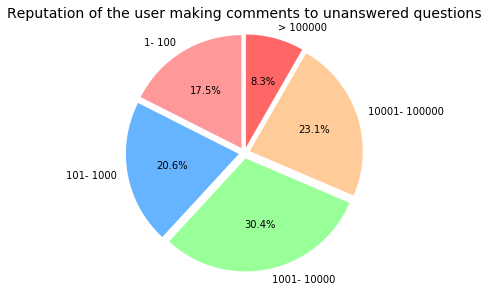

In [4]:
# Reputation of the user making comments to unanswered questions
query2 = '''
select 
    case
        when uc.reputation between 1 and 100 then '11- 100'
        when uc.reputation between 101 and 1000 then '2101- 1000'
        when uc.reputation between 1001 and 10000 then '31001- 10000'
        when uc.reputation between 10001 and 100000 then '410001- 100000'
        when uc.reputation > 100000 THEN '5> 100000'
    end as Reputation,
    sum(uc.num) as num
from(    
select u.reputation, count(*) as num
from `bigquery-public-data.stackoverflow.users` u
inner join(
    select c.user_id
    from `bigquery-public-data.stackoverflow.comments` c
    inner join (
        select id from `bigquery-public-data.stackoverflow.posts_questions`
        where answer_count = 0) q
    on post_id = q.id)
on id = user_id
group by reputation
order by reputation asc) uc
group by Reputation
order by Reputation
'''

temp2 = stackOverflow.query_to_pandas(query2)
temp2 = del_order_mark(temp2)

labels = temp2.Reputation
sizes = round(100 * temp2.num / temp2.num.sum(),2)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff6666']
explode = (0.05,0.05,0.05,0.05,0.05)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Reputation of the user making comments to unanswered questions", fontsize = 14)

# 3.TAG-BASED ANALYSIS
When asking a question, the questioner can choose up to 5
tags to label the question. A tag is a word or phrase that
describes the topic of the question, which is a mean of
connecting experts with questions they will be able to
answer by sorting questions into specific, well-defined
categories. Thus, tag can be used as an indicator of what
developers care about.

## 3.1 Topical Trend
There are more than 50,000 tags in SO. Some tags like
javascript are very popular among developer while the other
receive much less attention. The number of questions related
to the top 25, 50 and 100 tags are shown below

In [8]:
# pick out top 25 tags
query1 = '''
select tag_name, count
from `bigquery-public-data.stackoverflow.tags`
order by count desc
limit 25
'''

# pick out top 50 tags
query2 = '''
select tag_name, count
from `bigquery-public-data.stackoverflow.tags`
order by count desc
limit 50
'''

# pick out top 100 tags
query3 = '''
select tag_name, count
from `bigquery-public-data.stackoverflow.tags`
order by count desc
limit 100
'''

top_25_tag = stackOverflow.query_to_pandas(query1)
top_50_tag = stackOverflow.query_to_pandas(query2)
top_100_tag = stackOverflow.query_to_pandas(query3)

top_25_list = top_25_tag.tag_name.tolist()
top_50_list = top_50_tag.tag_name.tolist()
top_100_list = top_100_tag.tag_name.tolist()


# The following command are used for SQL query (I know it is kinda brute force......)
top_25_query_command = ''
for s in top_25_list:
    top_25_query_command += 'tags like \'%%|%s|%%\' or tags like \'%%|%s\' or tags like \'%s|%%\' or ' % (s,s,s)

top_50_query_command = ''
for s in top_50_list:
    top_50_query_command += 'tags like \'%%|%s|%%\' or tags like \'%%|%s\' or tags like \'%s|%%\' or ' % (s,s,s)

top_100_query_command = ''
for s in top_100_list:
    top_100_query_command += 'tags like \'%%|%s|%%\' or tags like \'%%|%s\' or tags like \'%s|%%\' or ' % (s,s,s)

    
# Delete the ' or ' at the end of the command
top_25_query_command = top_25_query_command[:-4]
top_50_query_command = top_50_query_command[:-4]
top_100_query_command = top_100_query_command[:-4]
  
    
# Feel free to have a look at the query statement
# print(top_25_query_command,end='\n\n')
# print(top_50_query_command,end='\n\n')
# print(top_100_query_command,end='\n\n')


query_top_25 = '''
select count(*) as num
from `bigquery-public-data.stackoverflow.posts_questions`
where  %s''' % top_25_query_command

query_top_50 = '''
select count(*) as num
from `bigquery-public-data.stackoverflow.posts_questions`
where  %s''' % top_50_query_command

query_top_100 = '''
select count(*) as num
from `bigquery-public-data.stackoverflow.posts_questions`
where  %s''' % top_100_query_command

query_num_question='''
select count(*) as num
from `bigquery-public-data.stackoverflow.posts_questions`
'''
top_25_num = stackOverflow.query_to_pandas(query_top_25).iat[0,0]
top_50_num = stackOverflow.query_to_pandas(query_top_50).iat[0,0]
top_100_num = stackOverflow.query_to_pandas(query_top_100).iat[0,0]
num_question = stackOverflow.query_to_pandas(query_num_question).iat[0,0]

temp = pd.DataFrame({"Top_N_tag":[25,50,100], "Number of Relevant Questions":[top_25_num, top_50_num, top_100_num]})
temp["Percentage(%)"] = round(temp["Number of Relevant Questions"] / num_question * 100, 2)
display(temp)

,Top_N_tag,Number of Relevant Questions,Percentage(%)
0,25,12328641,63.00
1,50,13820540,70.63
2,100,14909373,76.19


Based on the table above, only the top 25 tags are discussed in this part as they covered more than 60% questions and increasing the number of tags does not make much difference. By the way, the top 25 tags are listed below

In [9]:
print('Top 25 tags: \n',top_25_list)

# Feel free to check out top 50 tags and top 100 tags
# print('Top 50 tags: \n',top_50_list)
# print('Top 100 tags: \n',top_100_list)

Top 25 tags: 
 ['javascript', 'java', 'python', 'c#', 'php', 'android', 'html', 'jquery', 'c++', 'css', 'ios', 'mysql', 'sql', 'asp.net', 'r', 'c', 'arrays', 'node.js', 'ruby-on-rails', '.net', 'json', 'objective-c', 'sql-server', 'swift', 'angularjs']


To reflect the topical trend over the 11 years, a sliding time
window schema shown below is used

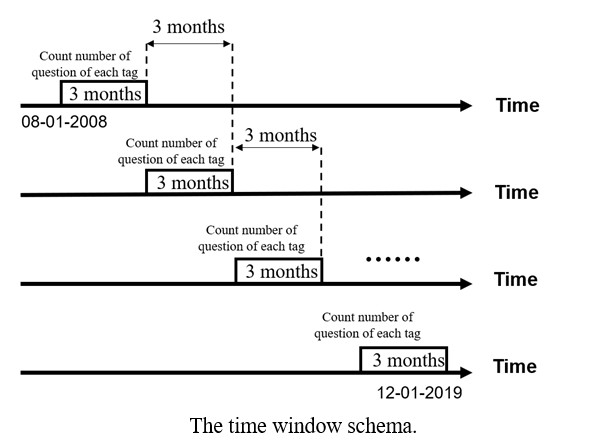

The window is fixed to be three-month long where the number of questions of each tag is counted. The window starts from 08-01-2008 and move 3 months forward at a time until it reaches 12-01-2019. The topical trend obtained by this method is shown below

In [10]:
# ================= !!! NOTE !!! ==============
# The code in this part is not efficient at all. 
# Running the code for the top 6 tags('javascript', 'java', 'c#', 'python', 'php','android') is okay 
# but doing it for all the top 25 tags is very time-consuming

import datetime
from dateutil.relativedelta import *

# tag_list = ['javascript', 'java', 'c#', 'python', 'php', 'android', 'jquery', 'html', 'c++', 'css', 'ios', 'mysql', 'sql', 'asp.net', 'r', 'c', 'arrays', 'ruby-on-rails', 'node.js', '.net', 'objective-c', 'json', 'sql-server', 'angularjs', 'swift']
tag_list = ['javascript', 'java', 'c#', 'python', 'php','android']

result = pd.DataFrame()
date_string_list = []

for tag in tag_list:
    start_date = datetime.datetime(2008,8,1)
    end_date = datetime.datetime(2008,11,1)
    final_date = datetime.datetime(2019,12,1)
    print('Now working on %s ......'%tag)
    
    temp = []
    while end_date < final_date:
        start_date_string = start_date.strftime('%Y-%m-%d')
        end_date_string = end_date.strftime('%Y-%m-%d')
        
        date_string_list.append(start_date_string)
        
        query = '''
        select count(*) as num
        from `bigquery-public-data.stackoverflow.posts_questions`
        where (tags like '%%|%s|%%' or tags like '%%|%s' or tags like '%s|%%')
        and date(creation_date) >= '%s' and date(creation_date) < '%s'
        ''' % (tag, tag, tag,start_date_string ,end_date_string)
        temp.append(stackOverflow.query_to_pandas(query).iat[0,0])
        
        start_date += relativedelta(months=+3)
        end_date += relativedelta(months=+3)
        
    result[tag] = temp
result.index = date_string_list[:len(date_string_list) // len(tag_list)]
print('Complete')


Now working on javascript ......
Now working on java ......
Now working on c# ......
Now working on python ......
Now working on php ......
Now working on android ......
Complete


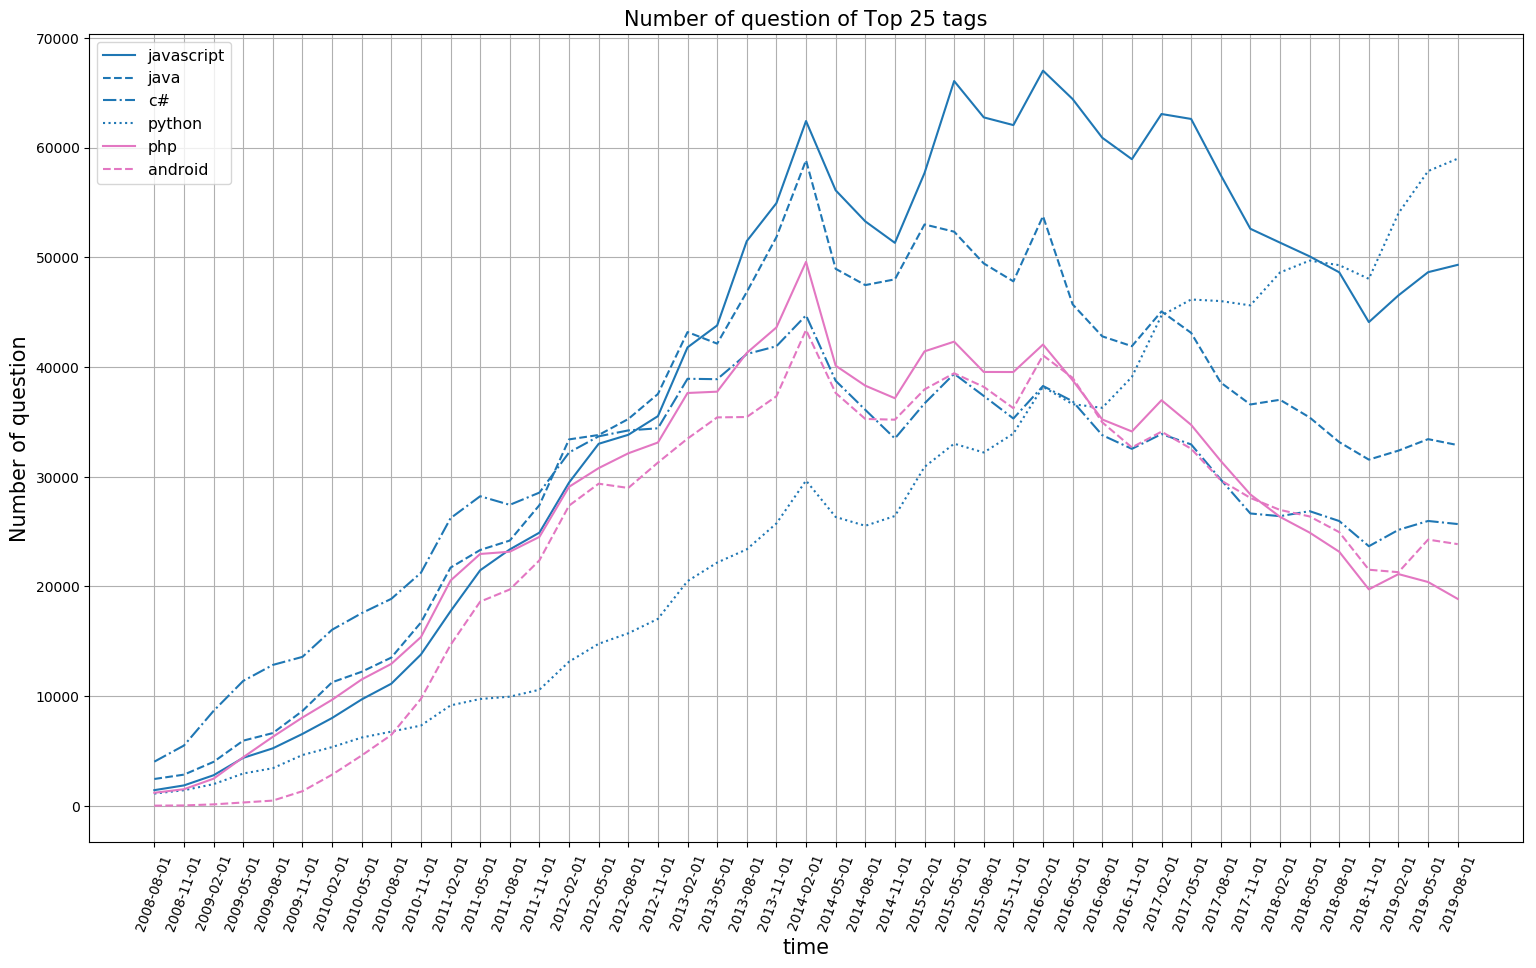

In [11]:
# Plot the topcial trend

matplotlib.style.use('default')
labelsize = 15
tag_list = result.columns.tolist()
x = result.index.tolist()

NUM_COLORS = len(tag_list)
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

cm = plt.get_cmap('tab10')
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(18.5, 10.5)
for i in range(NUM_COLORS):
    lines = ax.plot(x,result[tag_list[i]])
    lines[0].set_color(cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
    lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])

plt.setp(ax.xaxis.get_majorticklabels(), rotation=70 )
plt.legend(fontsize=11.38)
plt.grid(True)
plt.title("Number of question of Top 25 tags", fontsize=labelsize)
plt.xlabel('time',fontsize = labelsize)
plt.ylabel('Number of question',fontsize = labelsize)
plt.savefig('Number of question of Top 25 tags c')

[Complete result for all top 25 tags here](https://imgur.com/ClH6pjb)

Based on the graph above, javascript used to be the most popular tag. Python has been receiving more and more attention over the years and surpassed javascript on 08-01-2018, becoming the hottest topic.<br/><br/>
Besides, Php curve, c# curve and android curve share similar shape. This indicates that the three tags are often used to label a same question, which is reasonable as it is very possible to run into a problem associated with php, c# and android at the same time when developing an android-based web application.<br/><br/>
One should be aware that the growing number of questions is the result of two factors: one is the growing number of users and the other is the tag itself becoming more and more popular. In order to cancel the influence brought by growing number of users and focus on the tag itself, the same result is normalized by the total number of questions within each 3 months and shown below

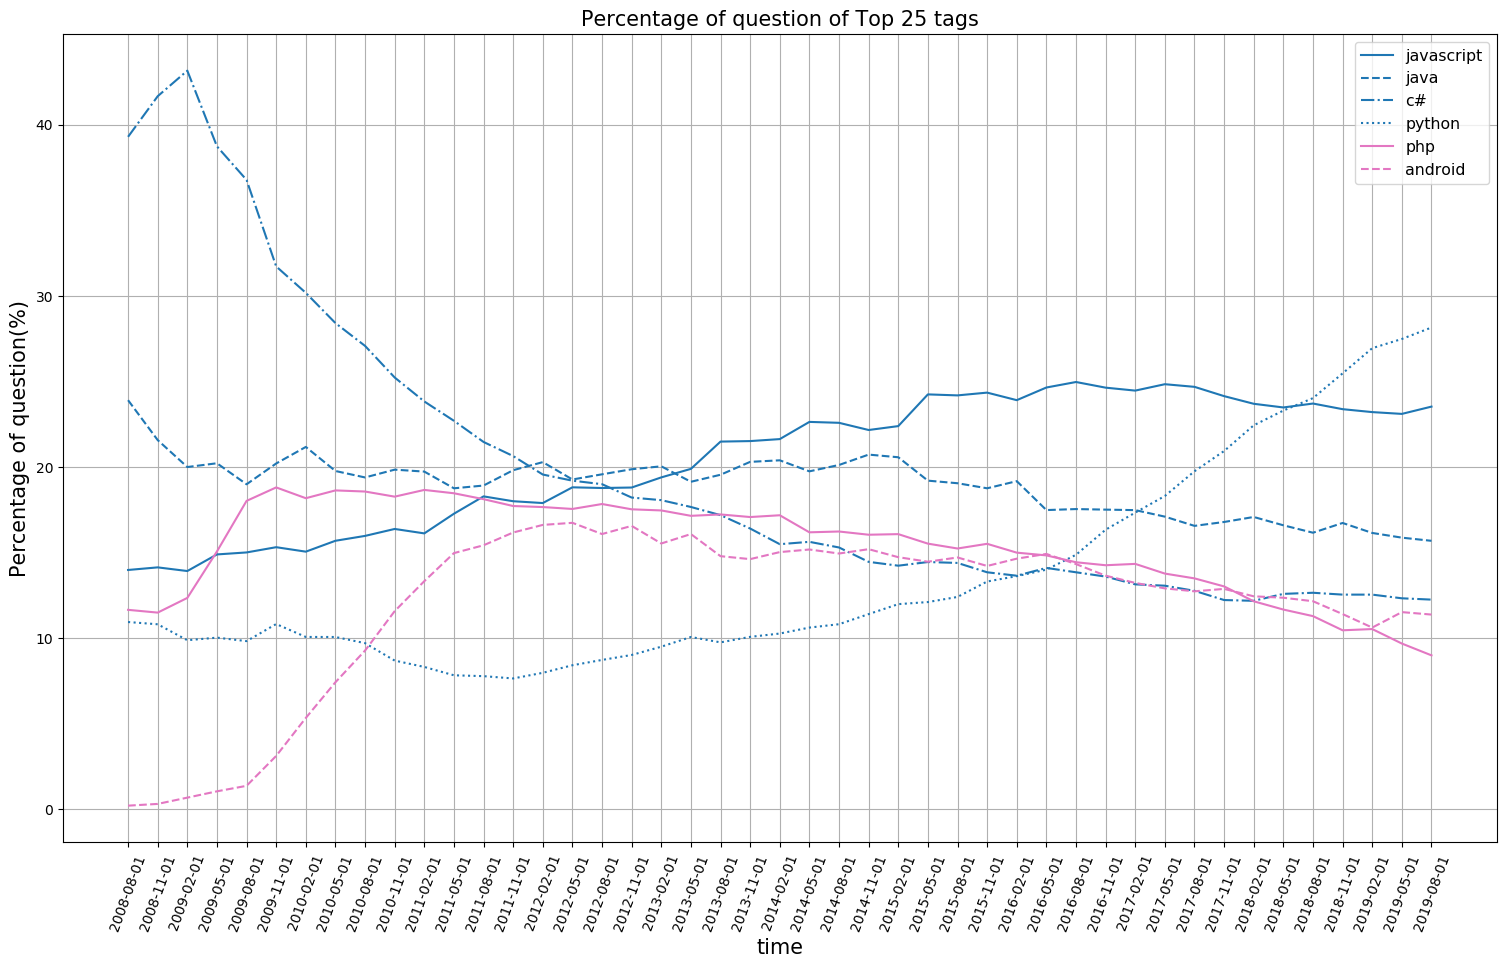

In [12]:
# plot percentage of each tag in every three months
labelsize = 15

tag_list = result.columns.tolist()
x = result.index.tolist()
result_new = result.div(result.sum(axis=1), axis=0) * 100 # normalize 

NUM_COLORS = len(tag_list)
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

cm = plt.get_cmap('tab10')
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(18.5, 10.5)
for i in range(NUM_COLORS):

    lines = ax.plot(x,result_new[tag_list[i]])
    lines[0].set_color(cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
    lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])

plt.setp(ax.xaxis.get_majorticklabels(), rotation=70 )
plt.legend(fontsize=11.38, bbox_to_anchor=(1, 1))
plt.grid(True)
plt.title("Percentage of question of Top 25 tags", fontsize=labelsize)
plt.xlabel('time',fontsize = labelsize)
plt.ylabel('Percentage of question(%)',fontsize = labelsize)
plt.savefig('Percentage of question of Top 25 tags')

[Complete result for all top 25 tags here](https://imgur.com/yewJEfk)

Now it is clear that c# used to be even more popular than any nowadays popular language, which is not easy to be noticed before normalization. However, developers’ focus is gradually changing from c# to javascript and python possibly because dynamic language like javacript and python are easier to learn and use.<br/><br/>
Java curve is steady over the years with its relative number remaining around 10%. This suggests that java is always an important topic for developers. However, c is not the same fortunate as java, which has been decreasing from 15% to 1.7%.

(By the way, the topical trend for all the top 25 tags is shown below. You may need more than one account to work out the same result yourself)

## 4.2 Variation-based event detection
Based on the result in the last section, some nowadays popular tags were not the same popular in the past. That means some events must have happened where those tags gain their popularity. This is the motivation of this section, to detect the event that makes a change. 
<br/><br/>If some event happens, for example python 3.0 is released, the amount of python questions is expected to be much more than before as python 3.0 is not compatible with its older version. After some time, users have run out of the question related to this event so that the amount of python question should return to normal level. In other words, the variance of the amount of the question is supposed to be higher than usual when an event happens. This is the key assumption of the variance-based event detection algorithm employed in this section. The mechanism of it is shown below

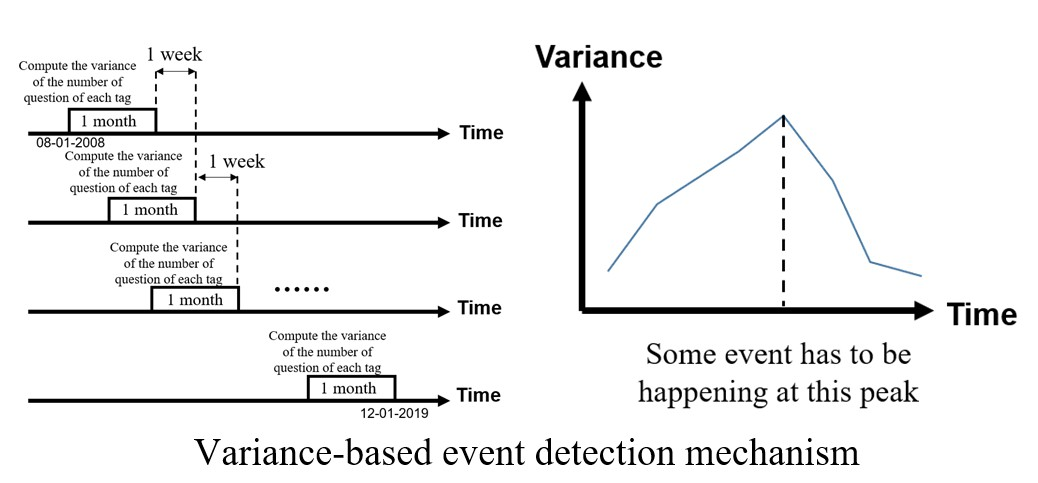

It is similar with the sliding time window schema as in the previous part. The time window is 1 month long where instead of counting the amount of questions of each tag, the variance of the amount of question is computed. The time window is moving forward 1 week at a time with 2 weeks overlapping with the previous window. The event is supposed to be detected at the time when there is a variance peak. The result is shown below

In [13]:
# ================= !!! NOTE !!! ==============
# The code in this part is even less efficient than the previous part. 
# Running the code may run out of your quota of query in the current month
# You may need more than one kaggle account to work out the complete result yourself
# Or you can try impoving the code yourself. I am not really good at sql :p

import datetime
from dateutil.relativedelta import *

# tag_list = ['javascript', 'java', 'c#', 'python', 'php', 'android', 'jquery', 'html', 'c++', 'css', 'ios', 'mysql', 'sql', 'asp.net', 'r', 'c', 'arrays', 'ruby-on-rails', 'node.js', '.net', 'objective-c', 'json', 'sql-server', 'angularjs', 'swift']
tag_list = ['javascript', 'java', 'c#', 'python', 'php','android']

result_var = pd.DataFrame()
date_string_list = []

for tag in tag_list:
    start_date = datetime.datetime(2008,8,1)
    end_date = datetime.datetime(2008,9,1)
    final_date = datetime.datetime(2019,12,1)
    print('Now working on %s ......'%tag)
    
    temp = []
    while end_date < final_date:
        start_date_string = start_date.strftime('%Y-%m-%d')
        end_date_string = end_date.strftime('%Y-%m-%d')
        
        date_string_list.append(start_date_string)
        
        query = '''
        select variance(num) as var
        from(
            select creation_date, count(*) as num
            from(
                select date(creation_date) as creation_date
                from `bigquery-public-data.stackoverflow.posts_questions`
                where (tags like '%%|%s|%%' or tags like '%%|%s' or tags like '%s|%%')
                and date(creation_date) >= '%s' and date(creation_date) < '%s')
            group by creation_date
            )
        ''' % (tag, tag, tag,start_date_string ,end_date_string)
        temp.append(stackOverflow.query_to_pandas(query).iat[0,0])
        
        start_date += relativedelta(days=+7)
        end_date += relativedelta(days=+7)
        
    result_var[tag] = temp
result_var.index = date_string_list[:len(date_string_list) // len(tag_list)]
print('Complete')
result_var.to_csv('result_var.csv')
print('Save Complete')

Now working on javascript ......
Now working on java ......
Now working on c# ......
Now working on python ......
Now working on php ......
Now working on android ......
Complete
Save Complete


[Complete topical trend for all 25 tags](https://imgur.com/airHRBw)

For javascript, the strongest peak is around the May and June in 2015 probably because at that time an important framework for javascript called Polymer is released by google, and in the following month ECMAScript 6 is also released, which is a standard for scripting language like javascript.<br/><br/>
Python curve has many prominent peaks which could be the turning point where python receives more attention. However, it is difficult to find out what events cause the variance peaks. There are thousands of hundreds of questions within each time window, which is infeasible for me alone to summarize the questions based on their semantic.<br/><br/>
This event-detecting algorithm is simple and intuitive, but it just tells us there should be an event or some events. In fact, it is very difficult to find out which event(s) lead to the variance peak because on the one hand, it is tedious to manually summarize the question based on their semantic and developing a program to automate this process would be extremely challenging. On the other hand, we do not know beforehand the variance is the result of a single strong event or multiple weak events. To interpret the result requires the knowledge out o data analysis, so this notebook just ends up here without any further exploration.

# Reference

[1] Asaduzzaman, M., Mashiyat, A.S., Roy, C.K. and Schneider, K.A., 2013, May. Answering questions about unanswered questions of stack overflow. In 2013 10th Working Conference on Mining Software Repositories (MSR) (pp. 97-100). IEEE.<br/><br/>
[2]  Anderson, A., Huttenlocher, D., Kleinberg, J. and Leskovec, J., 2012, August. Discovering value from community activity on focused question answering sites: a case study of stack overflow. In Proceedings of the 18th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 850-858).<br/><br/>
[3]  Cheng, J., Danescu-Niculescu-Mizil, C. and Leskovec, J., 2014, May. How community feedback shapes user behavior. In Eighth International AAAI Conference on Weblogs and Social Media.<br/><br/>
[4]  Wang, S., Lo, D. and Jiang, L., 2013, March. An empirical study on developer interactions in StackOverflow. In Proceedings of the 28th Annual ACM Symposium on Applied Computing (pp. 1019-1024).<br/><br/>
[5]  Movshovitz-Attias, D., Movshovitz-Attias, Y., Steenkiste, P. and Faloutsos, C., 2013, August. Analysis of the reputation system and user contributions on a question answering website: Stackoverflow. In 2013 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM 2013) (pp. 886-893). IEEE.<br/><br/>
[6]  Barua, A., Thomas, S.W. and Hassan, A.E., 2014. What are developers talking about? an analysis of topics and trends in stack overflow. Empirical Software Engineering, 19(3), pp.619-654.